In [43]:
import copy
from collections import Counter

import matplotlib.pyplot as plt
import numpy as np
from mitiq import zne
from qiskit import (IBMQ, ClassicalRegister, QuantumCircuit, QuantumRegister,
                    execute, transpile)
from qiskit.circuit import Parameter
from qiskit import Aer
from qiskit.utils.mitigation.fitters import (CompleteMeasFitter,
                                             TensoredMeasFitter)

from qiskit.visualization import plot_histogram
from qiskit.providers.aer.noise import NoiseModel

from lib import util

#from mitiq.interface.mitiq_qiskit.qiskit_utils import initialized_depolarizing_noise

In [44]:
from qiskit.test.mock import FakeManila
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q',
                            group='open', 
                            project='main')
#backend_sim_noisy_jakarta = Aer.from_backend(provider.get_backend('ibmq_manila'))
backend_real_jakarta = provider.get_backend('ibmq_manila')
backend_sim_ideal = Aer.get_backend('aer_simulator')
BACKEND = backend_real_jakarta

noise_model = NoiseModel.from_backend(BACKEND)

# Get coupling map from backend
coupling_map = BACKEND.configuration().coupling_map

# Get basis gates from noise model
basis_gates = noise_model.basis_gates

ibmqfactory.load_account:WARNING:2022-11-22 15:37:42,311: Credentials are already in use. The existing account in the session will be replaced.


In [45]:
qubits_measure=[0,1,2,3,4]
qubits=qubits_measure
shots=10000
config=BACKEND.configuration()
N_qubits_backend=config.n_qubits
dt=0.08
#N_steps=15

In [46]:
qr_trot=QuantumRegister(N_qubits_backend,name='q')
qc_trot=QuantumCircuit(qr_trot)

for i in range (0,N_qubits_backend):
    qc_trot.rz(dt/2,qr_trot[i])

qc_trot.cx(qr_trot[1],qr_trot[2])
qc_trot.cx(qr_trot[3],qr_trot[2])
qc_trot.cx(qr_trot[0],qr_trot[1])
qc_trot.cx(qr_trot[4],qr_trot[3])

qc_trot.rx(dt,qr_trot[0])
qc_trot.rx(dt,qr_trot[4])

qc_trot.cx(qr_trot[4],qr_trot[3])
qc_trot.cx(qr_trot[0],qr_trot[1])
qc_trot.cx(qr_trot[3],qr_trot[2])
qc_trot.cx(qr_trot[1],qr_trot[2])
for i in range (0,N_qubits_backend):
    qc_trot.rz(dt/2,qr_trot[i])

qc_trot.draw()

┌──────────┐          ┌──────────┐            ┌──────────┐            »
q_0: ┤ Rz(0.04) ├───────■──┤ Rx(0.08) ├─────■──────┤ Rz(0.04) ├────────────»
     ├──────────┤     ┌─┴─┐└──────────┘   ┌─┴─┐    └──────────┘            »
q_1: ┤ Rz(0.04) ├──■──┤ X ├───────────────┤ X ├────────────────────────────»
     ├──────────┤┌─┴─┐├───┤               └───┘                   ┌───┐    »
q_2: ┤ Rz(0.04) ├┤ X ├┤ X ├───────────────────────────────────────┤ X ├────»
     ├──────────┤└───┘└─┬─┘   ┌───┐                   ┌───┐       └─┬─┘    »
q_3: ┤ Rz(0.04) ├───────■─────┤ X ├───────────────────┤ X ├─────────■──────»
     ├──────────┤             └─┬─┘    ┌──────────┐   └─┬─┘    ┌──────────┐»
q_4: ┤ Rz(0.04) ├───────────────■──────┤ Rx(0.08) ├─────■──────┤ Rz(0.04) ├»
     └──────────┘                      └──────────┘            └──────────┘»
«                             
«q_0: ────────────────────────
«                 ┌──────────┐
«q_1: ─────■──────┤ Rz(0.04) ├
«        ┌─┴─┐    ├──────────┤
«q_2: ───┤ X ├────┤ Rz(0.04) ├
«     ┌──┴───┴───┐└──────────┘
«q_3: ┤ Rz(0.04) ├────────────
«     └──────────┘            
«q_4: ────────────────────────
«

In [47]:
def final_circ(N_trot):
    qr=QuantumRegister(N_qubits_backend,name='q')
    qc=QuantumCircuit(qr)

    for i in range (0,N_trot):
        qc.append(qc_trot,qr)
    return qc

In [48]:
backend=backend_sim_ideal
qr = QuantumRegister(N_qubits_backend)
meas_calibs, state_labels = util.qiskit_calibration_circuits(N_qubits_backend,qubits_measure=qubits_measure)
print(len(meas_calibs))
job_cal = execute(meas_calibs, Aer.get_backend('qasm_simulator'),
                 coupling_map=coupling_map,
                 basis_gates=basis_gates,
                 noise_model=noise_model)
#job_cal.queue_position(refresh=True)
cal_results = job_cal.result()
cal_counts=cal_results.get_counts()
#print(cal_counts)
meas_fitter = CompleteMeasFitter(cal_results, state_labels)

32


In [49]:
def circs_run(circs,qcirc,backend=BACKEND,qubits_measure=qubits_measure):
    
    qcirc=transpile(qcirc,backend,optimization_level=0)
    cal_circs_meas, s_labels = util.qiskit_calibration_circuits(N_qubits_backend,qubits_measure=qubits_measure)
    cal_circs_GEM, s_labels = util.GEM_calibration_circuits(qc=qcirc,qubits_measure=qubits_measure)
    a=transpile(cal_circs_GEM[0][0],backend,optimization_level=0)
    print(a.count_ops())
    b=transpile(cal_circs_GEM[0][1],backend,optimization_level=0)
    print(b.count_ops())
    c=transpile(cal_circs_GEM[1][0],backend,optimization_level=0)
    print(c.count_ops())
    d=transpile(cal_circs_GEM[1][1],backend,optimization_level=0)
    print(d.count_ops())

    circs += cal_circs_meas
    print(len(cal_circs_meas))
    circs += cal_circs_GEM[0]
    
    print(len(cal_circs_GEM[0]))
    circs += cal_circs_GEM[1]
    print(len(cal_circs_GEM[1]))
    #print(cal_circs_GEM[1][0].count_ops())

    qr_aux=QuantumRegister(N_qubits_backend,name='q')
    cr=ClassicalRegister(len(qubits_measure))
    qc=QuantumCircuit(qr_aux,cr)

    qc.append(qcirc,qr_aux)
    qc=transpile(qc,backend,optimization_level=0)
    for i in range (0,len(qubits_measure)):
        qc.measure([qr_aux[qubits_measure[i]]],[cr[i]])
    circs.append(qc)

    

    return circs,s_labels


In [50]:
def simulation(N_steps):

    circs=[]
    circs,s_labels=circs_run(circs,final_circ(N_steps))
    print(len(circs))
    
    job=execute(circs,Aer.get_backend('qasm_simulator'),
                    coupling_map=coupling_map,
                    basis_gates=basis_gates,
                    noise_model=noise_model,
                    shots=shots,
                    optimization_level=0)
    '''
    job=execute(circs,BACKEND,
                    shots=shots,
                    optimization_level=0)    
    '''       
    job_result=job.result()
    job_counts=job_result.get_counts()
    job_qiskit=copy.deepcopy(cal_results)
    job_GEM_L=copy.deepcopy(cal_results)
    job_GEM_R=copy.deepcopy(cal_results)
    for j in range (0,len(s_labels)):
        job_qiskit.results[j].data.counts=job_counts[j]
    meas_fitter=CompleteMeasFitter(job_qiskit,s_labels)
    C_qiskit=meas_fitter.cal_matrix
    for j in range (0,len(s_labels)):
        job_GEM_L.results[j].data.counts=meas_fitter.filter.apply(job_counts[j+len(s_labels)],method="least_squares")
        job_GEM_R.results[j].data.counts=meas_fitter.filter.apply(job_counts[j+2*len(s_labels)],method="least_squares")

    meas_fitter_GEM_L = CompleteMeasFitter(job_GEM_L, state_labels=s_labels)
    meas_fitter_GEM_R = CompleteMeasFitter(job_GEM_R, state_labels=s_labels)
    Cal_GEM_L = meas_fitter_GEM_L.cal_matrix
    Cal_GEM_R = meas_fitter_GEM_R.cal_matrix
    C=(Cal_GEM_L+Cal_GEM_R)/2
        
        #define the equilibrium counts distribution
    rand_vec_prob=np.sum(C,axis=1,dtype='float')/(len(s_labels))
        
        
        #calculate the probaabilities of dep error
    p_t=(C[0][0]-1)/(rand_vec_prob[0]-1)
    print('p_t')
    print(p_t)

        #define the random prob vector and equilibrium prob vector
    print('rand_vec')
    print(rand_vec_prob)
    rand_vec=p_t*shots*rand_vec_prob

    D=np.zeros((len(s_labels),len(s_labels)))

    for k in range (0,len(s_labels)):
        for j in range (0,len(s_labels)):
            D[k][j]=(C[k][j]-p_t*rand_vec_prob[k])/(1-p_t)
    CGP=D
        
        
    meas_fitter_GP=copy.deepcopy(meas_fitter)
    meas_fitter_GP.cal_matrices=CGP

    meas_fitter_GEM=copy.deepcopy(meas_fitter)
    meas_fitter_GEM.cal_matrices=C

    job_counts_circ_raw=job_counts[-1]
    raw_vector=util.occurrences_to_vector(job_counts_circ_raw)
    new_vector_CGP=(raw_vector-rand_vec)/(1-p_t)
    new_counts=dict(zip(s_labels,new_vector_CGP))
    job_counts_circ_CGP=meas_fitter_GP.filter.apply(new_counts,method="least_squares")
    job_counts_circ_qiskit=meas_fitter.filter.apply(job_counts[-1],method="least_squares")
    job_counts_circ_GEM=meas_fitter_GEM.filter.apply(job_counts_circ_qiskit,method="least_squares")

    job_ideal=execute(circs[-1],backend=backend_sim_ideal,shots=shots,optimization_level=0)
    job_counts=job_ideal.result().get_counts()

    return job_counts_circ_raw,job_counts_circ_CGP,job_counts_circ_GEM,job_counts_circ_qiskit,job_counts,C,D,C_qiskit,p_t,rand_vec[0]


In [51]:
p_raw=[]
p_qiskit=[]
p_GEM=[]
p_CGP=[]
p_ideal=[]
C_GEM=[]
C_CGP=[]
C_qiskit=[]
p=[]
rand_vec=[]

for i in range (1,30):
    counts_raw,counts_CGP,counts_GEM,counts_qiskit,counts_ideal,C,G,Q,p_t,r=simulation(i)
    C_GEM.append(C)
    C_CGP.append(G)
    C_qiskit.append(Q)
    p.append(p_t)
    rand_vec.append(r)
    for output in ['00000']:
        if output in counts_GEM:
            p_GEM.append(counts_GEM[output]/shots)
        else:
            p_GEM.append(0)
    
    for output in ['00000']:
        if output in counts_raw:
            p_raw.append(counts_raw[output]/shots)
        else:
            p_raw.append(0)
    for output in ['00000']:
        if output in counts_CGP:
            p_CGP.append(counts_CGP[output]/shots)
        else:
            p_CGP.append(0)
    for output in ['00000']:
        if output in counts_qiskit:
            p_qiskit.append(counts_qiskit[output]/shots)
        else:
            p_qiskit.append(0)
    
    for output in ['00000']:
        if output in counts_ideal:
            p_ideal.append(counts_ideal[output]/shots)
        else:
            p_ideal.append(0)


OrderedDict([('rz', 24), ('cx', 8), ('sx', 6), ('measure', 5)])
OrderedDict([('rz', 24), ('cx', 8), ('sx', 6), ('measure', 5), ('x', 1)])
OrderedDict([('rz', 18), ('cx', 8), ('sx', 6), ('measure', 5)])
OrderedDict([('rz', 18), ('cx', 8), ('sx', 6), ('measure', 5), ('x', 1)])
32
32
32
97
p_t
0.01754667966697382
rand_vec
[0.03230266 0.03219882 0.03153434 0.03166459 0.03213865 0.03121744
 0.03132757 0.03160643 0.03156189 0.03153905 0.03112451 0.03102541
 0.03218002 0.03119262 0.03134939 0.03124001 0.03195725 0.03128928
 0.03079919 0.03053808 0.03113948 0.03077719 0.03084153 0.03074672
 0.03119095 0.03056963 0.0309822  0.03053006 0.03127343 0.03094116
 0.03087152 0.03034894]
OrderedDict([('rz', 46), ('cx', 16), ('sx', 12), ('measure', 5)])
OrderedDict([('rz', 46), ('cx', 16), ('sx', 12), ('measure', 5), ('x', 1)])
OrderedDict([('rz', 40), ('cx', 16), ('sx', 12), ('measure', 5)])
OrderedDict([('rz', 40), ('cx', 16), ('sx', 12), ('measure', 5), ('x', 1)])
32
32
32
97
p_t
0.028322036798101545

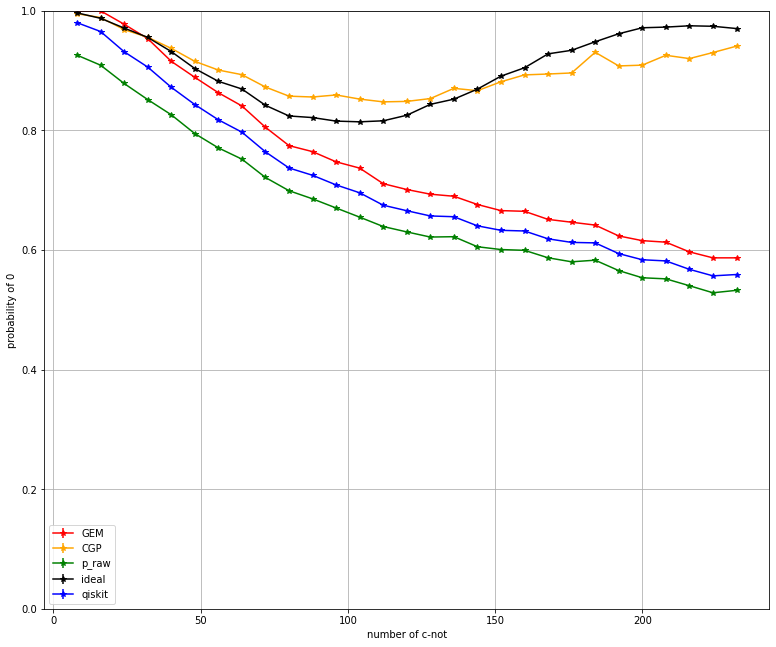

In [ ]:

n=np.arange(1,len(p_GEM)+1,1)
n=n*8
db=0.000000001



plt.figure(figsize=(13,11))
plt.errorbar(n,p_GEM, db, linestyle='-', marker='*', color= 'red',label='GEM')
plt.errorbar(n,p_CGP, db, linestyle='-', marker='*', color= 'orange',label='CGP')
plt.errorbar(n,p_raw, db, linestyle='-', marker='*', color= 'green',label='p_raw')
plt.errorbar(n,p_ideal, db, linestyle='-', marker='*', color= 'black',label='ideal')
plt.errorbar(n,p_qiskit, db, linestyle='-', marker='*', color= 'blue',label='qiskit')



plt.xlabel('number of c-not')
plt.ylabel(r'probability of 0')
plt.ylim(0,1)
plt.legend()
plt.grid()
plt.show()

In [56]:
for i in range (0,len(rand_vec)):
    rand_vec[i]=rand_vec[i]/shots

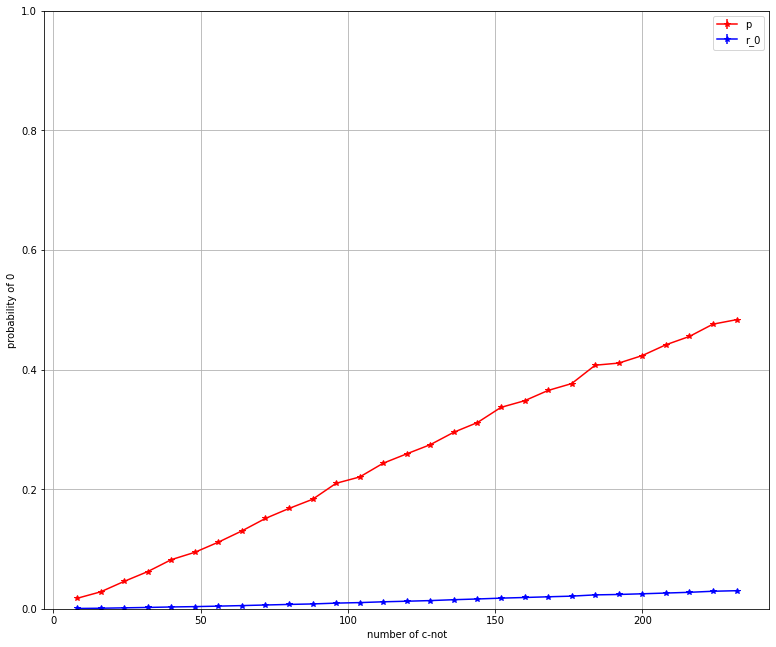

In [58]:
n=np.arange(1,len(p_GEM)+1,1)
n=n*8
db=0.000000001



plt.figure(figsize=(13,11))
plt.errorbar(n,p, db, linestyle='-', marker='*', color= 'red',label='p')
plt.errorbar(n,rand_vec, db, linestyle='-', marker='*', color= 'blue',label='r_0')

plt.xlabel('number of c-not')
plt.ylabel(r'probability of 0')
plt.ylim(0,1)
plt.legend()
plt.grid()
plt.show()

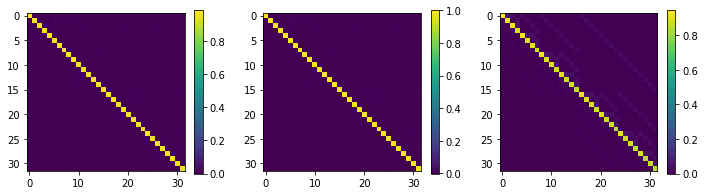

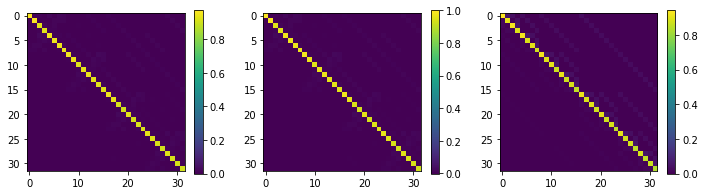

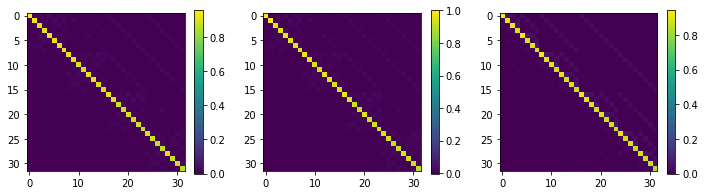

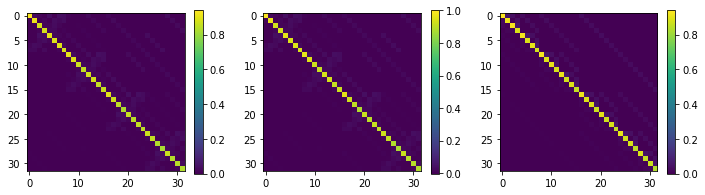

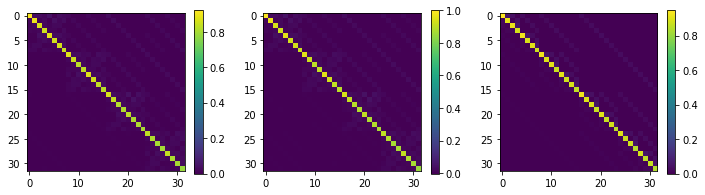

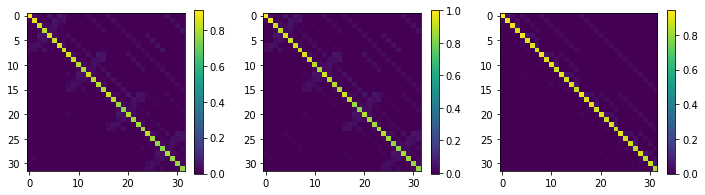

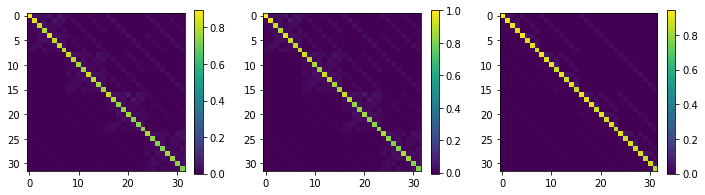

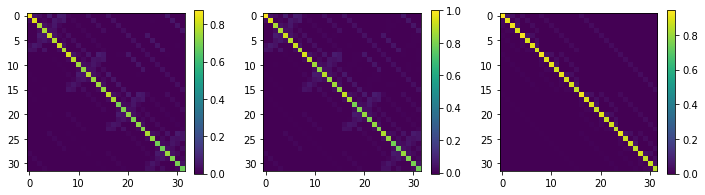

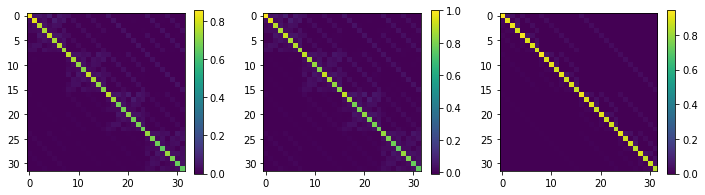

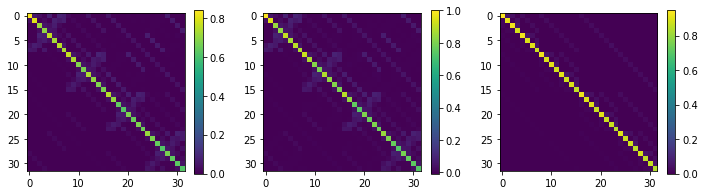

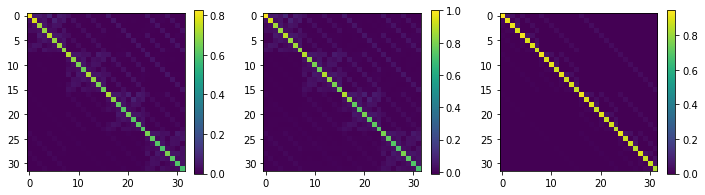

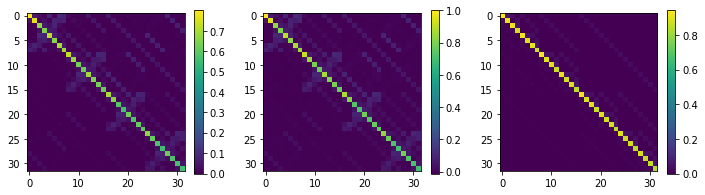

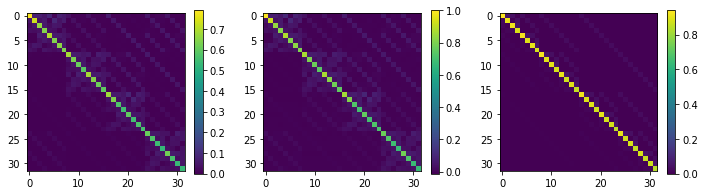

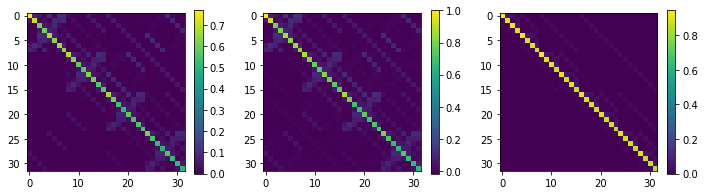

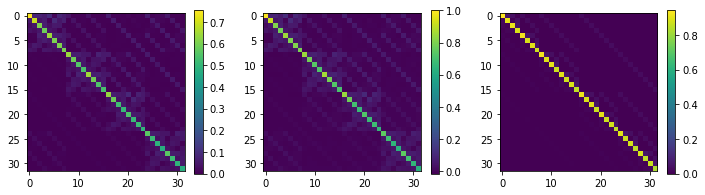

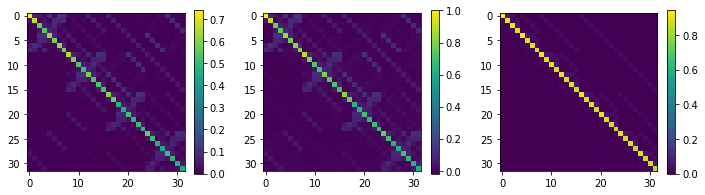

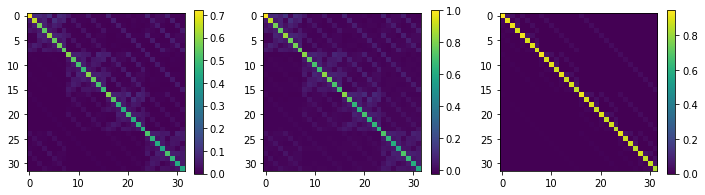

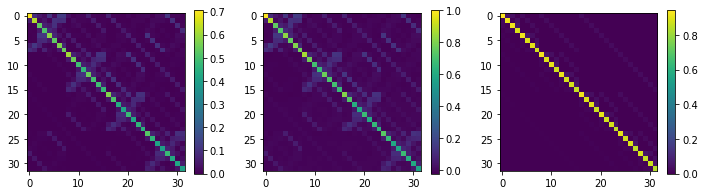

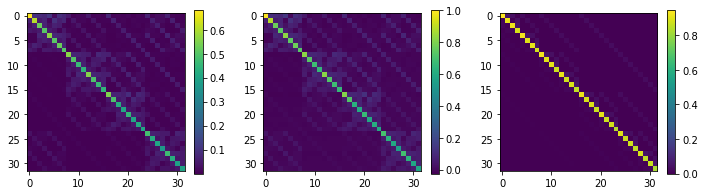

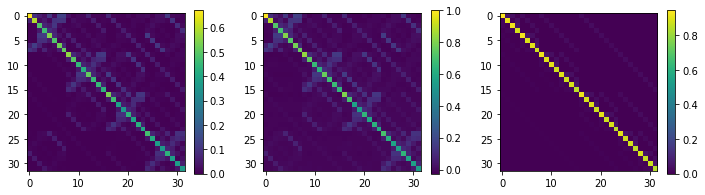

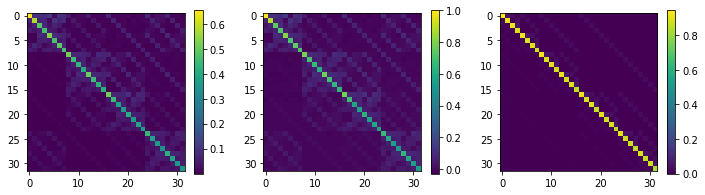

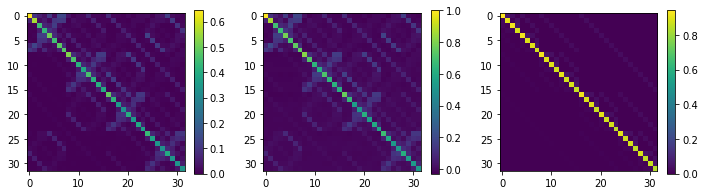

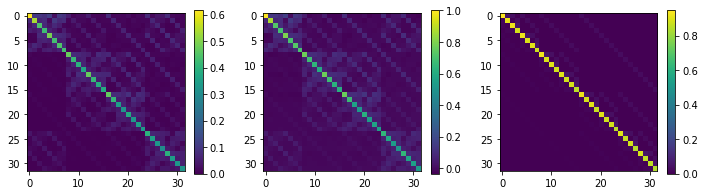

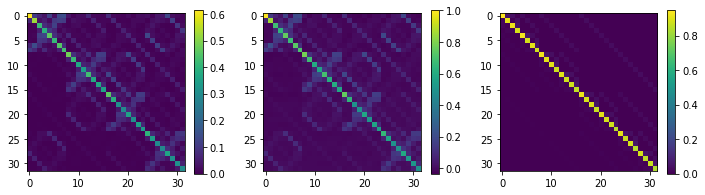

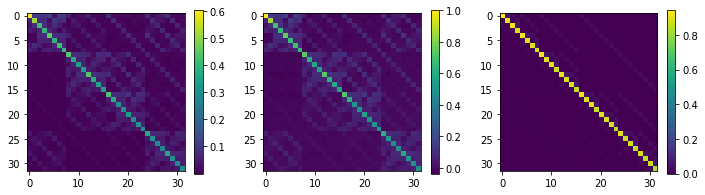

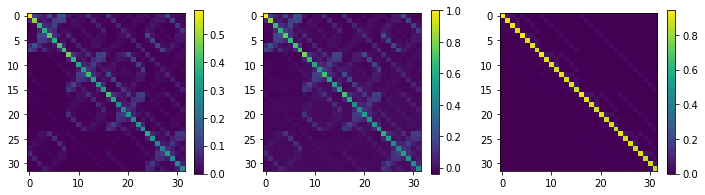

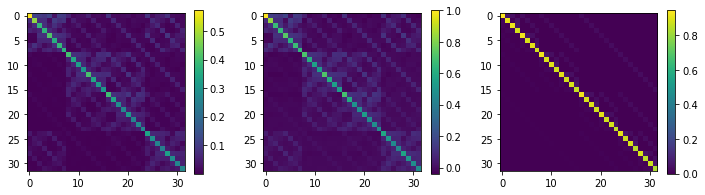

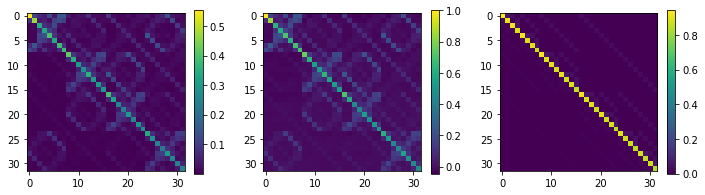

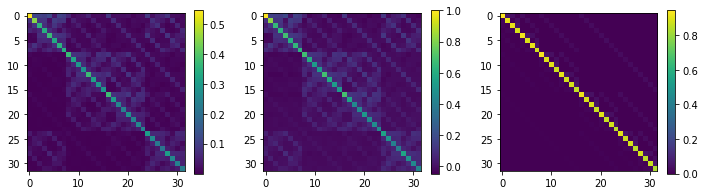

In [54]:
for i in range (0,len(C_GEM)):
    plt.figure(figsize=(12,3))
    plt.subplot(131)
    plt.imshow(C_GEM[i])
    plt.colorbar()
    plt.subplot(132)
    plt.imshow(C_CGP[i])
    plt.colorbar()
    plt.subplot(133)
    plt.imshow(C_qiskit[i])
    plt.colorbar()
    plt.show()

In [ ]:
qr=QuantumRegister(N_qubits_backend)
cr=ClassicalRegister(len(qubits_measure))
qc=QuantumCircuit(qr,cr)

for i in range (0,10):
    qc.append(qc_trot,qr)

for i in range (0,len(qubits_measure)):
    qc.measure([qr[qubits_measure[i]]],[cr[i]])
circuit =  qc
    # Convert from raw measurement counts to the expectation value
scale_factors = [1., 2., 3.]
folded_circuits = [
     zne.scaling.fold_all(circuit, scale)
        for scale in scale_factors
]
job_zne = execute(
    experiments=folded_circuits,
    backend=Aer.get_backend('qasm_simulator'),
    coupling_map=coupling_map,
    basis_gates=basis_gates,
    noise_model=noise_model,
    optimization_level=0,  # Important to preserve folded gates.
    shots=shots,
)
    # Check that the circuit depth is (approximately) scaled as expected
#print(a)
for j, c in enumerate(folded_circuits):
    print(f"Number of gates of folded circuit {j} scaled by: {len(c) / len(circuit):.3f}")
counts_zne=np.zeros(len(s_labels))
all_counts = [job_zne.result().get_counts(i) for i in range(len(folded_circuits))]
z=np.zeros(len(s_labels))
for i in range (0,len(s_labels)):
    string=s_labels[i]
    expectation_values=[]
    for counts in all_counts:
        if string in counts:
            expectation_values.append(counts[string] / shots)
        else:
            expectation_values.append(0)
    z[i] = zne.RichardsonFactory.extrapolate(scale_factors, expectation_values)*shots

new_counts_zne=dict(zip(util.bin_list(2),z))
print(new_counts_zne)


CircuitConversionError: Circuit could not be converted to an internal Mitiq circuit. This may be because the circuit contains custom gates or Pragmas (pyQuil). If you think this is a bug or that this circuit should be supported, you can open an issue at https://github.com/unitaryfund/mitiq. 

Provided circuit has type <class 'qiskit.circuit.quantumcircuit.QuantumCircuit'> and is:

         ┌────────────────┐┌────────────────┐┌────────────────┐»
q3597_0: ┤0               ├┤0               ├┤0               ├»
         │                ││                ││                │»
q3597_1: ┤1               ├┤1               ├┤1               ├»
         │                ││                ││                │»
q3597_2: ┤2 circuit-24282 ├┤2 circuit-24282 ├┤2 circuit-24282 ├»
         │                ││                ││                │»
q3597_3: ┤3               ├┤3               ├┤3               ├»
         │                ││                ││                │»
q3597_4: ┤4               ├┤4               ├┤4               ├»
         └────────────────┘└────────────────┘└────────────────┘»
  c11: 5/══════════════════════════════════════════════════════»
                                                               »
«         ┌────────────────┐┌────────────────┐┌────────────────┐»
«q3597_0: ┤0               ├┤0               ├┤0               ├»
«         │                ││                ││                │»
«q3597_1: ┤1               ├┤1               ├┤1               ├»
«         │                ││                ││                │»
«q3597_2: ┤2 circuit-24282 ├┤2 circuit-24282 ├┤2 circuit-24282 ├»
«         │                ││                ││                │»
«q3597_3: ┤3               ├┤3               ├┤3               ├»
«         │                ││                ││                │»
«q3597_4: ┤4               ├┤4               ├┤4               ├»
«         └────────────────┘└────────────────┘└────────────────┘»
«  c11: 5/══════════════════════════════════════════════════════»
«                                                               »
«         ┌────────────────┐┌────────────────┐┌────────────────┐»
«q3597_0: ┤0               ├┤0               ├┤0               ├»
«         │                ││                ││                │»
«q3597_1: ┤1               ├┤1               ├┤1               ├»
«         │                ││                ││                │»
«q3597_2: ┤2 circuit-24282 ├┤2 circuit-24282 ├┤2 circuit-24282 ├»
«         │                ││                ││                │»
«q3597_3: ┤3               ├┤3               ├┤3               ├»
«         │                ││                ││                │»
«q3597_4: ┤4               ├┤4               ├┤4               ├»
«         └────────────────┘└────────────────┘└────────────────┘»
«  c11: 5/══════════════════════════════════════════════════════»
«                                                               »
«         ┌────────────────┐┌─┐            
«q3597_0: ┤0               ├┤M├────────────
«         │                │└╥┘┌─┐         
«q3597_1: ┤1               ├─╫─┤M├─────────
«         │                │ ║ └╥┘┌─┐      
«q3597_2: ┤2 circuit-24282 ├─╫──╫─┤M├──────
«         │                │ ║  ║ └╥┘┌─┐   
«q3597_3: ┤3               ├─╫──╫──╫─┤M├───
«         │                │ ║  ║  ║ └╥┘┌─┐
«q3597_4: ┤4               ├─╫──╫──╫──╫─┤M├
«         └────────────────┘ ║  ║  ║  ║ └╥┘
«  c11: 5/═══════════════════╩══╩══╩══╩══╩═
«                            0  1  2  3  4 

Circuit types supported by Mitiq are 
{'cirq': 'Circuit', 'pyquil': 'Program', 'qiskit': 'QuantumCircuit', 'braket': 'Circuit', 'pennylane': 'QuantumTape'}.

In [ ]:
new_counts_zne=dict(zip(util.bin_list(2),z))


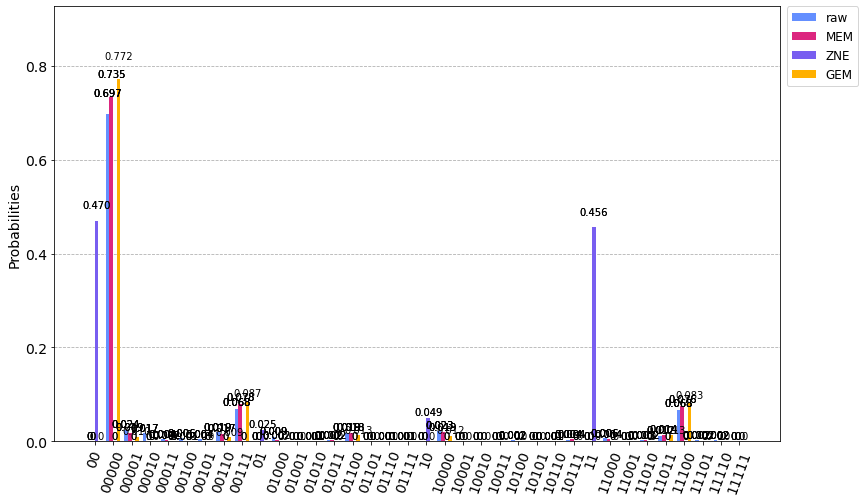

In [ ]:
legend = ['raw', 'MEM','ZNE','GEM']#,'CGP','ZNE']
plot_histogram([job_counts_circ_raw, job_counts_circ_qiskit,new_counts_zne,job_counts_circ_GEM],legend=legend,figsize=(13,8))#,job_counts_circ_CGP,new_counts_zne], legend=legend,figsize=(13,8))